In [125]:
# --- Imports
import matplotlib
import matplotlib.pyplot as plt
import torch
torch.set_default_dtype(torch.float64)
import pandas as pd
import numpy as np
from numpy import round
import scipy.stats as stats
import kan
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

In [91]:
# --- Loading Data
CHF = pd.read_csv("NE795_SciML_HW1_CHF_dataset_public.csv")
X_features = ["Tube Diameter", "Heated Length", "Pressure", "Mass Flux", "Outlet Quality", "Inlet Subcooling", "Inlet Temperature"]
Y_features = ["CHF"]
X_units = CHF.loc[0,X_features] #type:ignore
Y_units = CHF.loc[0,Y_features] #type:ignore
X_SCALER = StandardScaler()
Y_SCALER = StandardScaler()
X = CHF.loc[1:,X_features].astype(float).values
Y = CHF.loc[1:,Y_features].astype(float).values



In [96]:
# --- Test Train Split
X_TRAIN, X_TESTS, Y_TRAIN, Y_TESTS = train_test_split(X, Y, test_size=0.25)
X_TRAIN_SCALED = torch.tensor(X_SCALER.fit_transform(X_TRAIN))
X_TESTS_SCALED = torch.tensor(X_SCALER.transform(X_TESTS))
Y_TRAIN_SCALED = torch.tensor(Y_SCALER.fit_transform(Y_TRAIN))
Y_TESTS_SCALED = torch.tensor(Y_SCALER.transform(Y_TESTS))
DATASET = {'train_input':X_TRAIN_SCALED, 'test_input':X_TESTS_SCALED, 'train_label':Y_TRAIN_SCALED, 'test_label':Y_TESTS_SCALED}

In [97]:
print(f"X Features Shape:\t({X.shape[0]} Samples) x ({X.shape[1]} Features)\t\tSplit Into: ({X_TRAIN.shape[0]}/{X_TESTS.shape[0]}) Train/Test Samples")
print(f"Y Features Shape:\t({Y.shape[0]} Samples) x ({Y.shape[1]} Features)\t\tSplit Into: ({Y_TRAIN.shape[0]}/{Y_TESTS.shape[0]}) Train/Test Samples")

X Features Shape:	(24579 Samples) x (7 Features)		Split Into: (18434/6145) Train/Test Samples
Y Features Shape:	(24579 Samples) x (1 Features)		Split Into: (18434/6145) Train/Test Samples


In [98]:
# --- Constructing and Initial Training
model = kan.KAN(width=[X.shape[1], 7, Y.shape[1]], grid=3, seed=43, device='cpu')

checkpoint directory created: ./model
saving model version 0.0


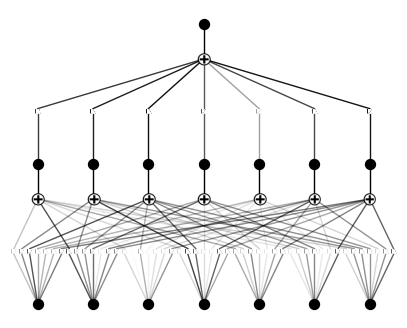

In [99]:
model(DATASET['train_input'])
model.plot()

In [100]:
model.fit(DATASET, opt='LBFGS', steps=50, lamb=0.001)
print("Complete.")

| train_loss: 7.49e-02 | test_loss: 8.60e-02 | reg: 1.44e+01 | : 100%|█| 50/50 [01:49<00:00,  2.18s/

saving model version 0.1
Complete.


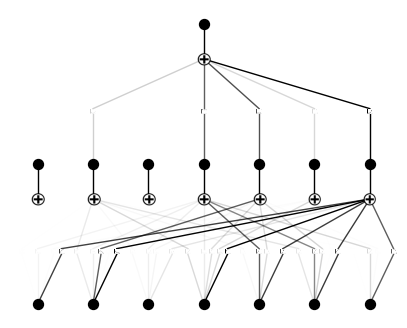

In [101]:
model.plot()

saving model version 0.2


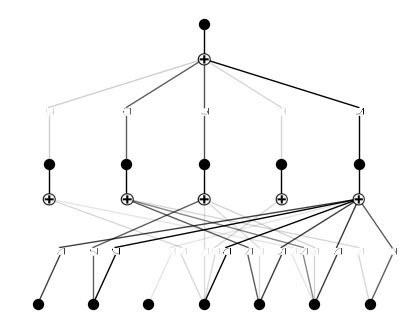

In [102]:
# --- Model Pruning and Refinement
model = model.prune()
model.plot()

In [103]:
model = model.refine(10)

saving model version 0.3


In [104]:
model.fit(DATASET, opt='LBFGS', steps=100)
print("Complete")

| train_loss: 5.64e-02 | test_loss: 6.50e-02 | reg: 1.57e+01 | : 100%|█| 100/100 [04:43<00:00,  2.83

saving model version 0.4
Complete


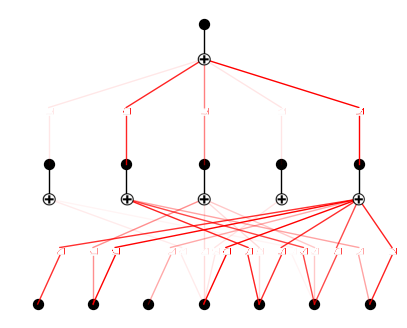

In [138]:
model.plot()

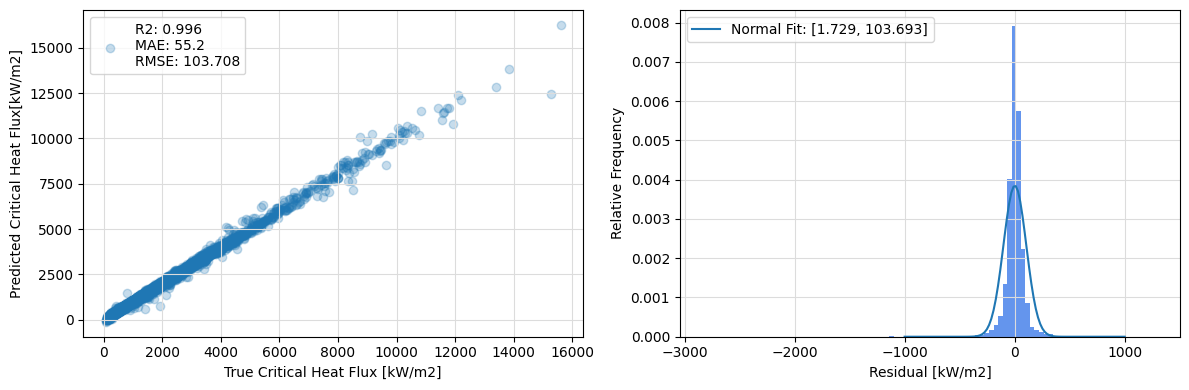

In [134]:
# --- Results - Performance
Y_PREDICTED = Y_SCALER.inverse_transform(model(X_TESTS_SCALED).detach().reshape(-1,1))
Y_TRUE = Y_TESTS
myR2 = R2(Y_TRUE, Y_PREDICTED); myMSE = MSE(Y_TRUE, Y_PREDICTED); myMAE = MAE(Y_TRUE, Y_PREDICTED)

fig, axs = plt.subplots(1,2, figsize=(12,4))

ax=axs[0]
ax.scatter(Y_TRUE, Y_PREDICTED, alpha=0.25, label=f"R2: {round(myR2,3)}\nMAE: {round(myMAE,3)}\nRMSE: {round(myMSE**0.5,3)}")
ax.set_xlabel("True Critical Heat Flux [kW/m2]"); ax.set_ylabel("Predicted Critical Heat Flux[kW/m2]"); ax.legend(); ax.grid(visible=True, color='gainsboro')

ax=axs[1]
residuals = Y_PREDICTED - Y_TRUE
pdf_fit = stats.norm.fit(residuals)
pdf_pdf = stats.norm.pdf(np.linspace(-1000,1000,100), *pdf_fit)
ax.hist(residuals, bins=100, color='cornflowerblue', density=True)
ax.plot(np.linspace(-1000,1000,100), pdf_pdf, label=f'Normal Fit: {[round(i,3) for i in pdf_fit]}')
ax.set_xlabel("Residual [kW/m2]"); ax.set_ylabel("Relative Frequency"); ax.grid(visible=True, color='gainsboro', label='Raw Data'); ax.legend()

fig.tight_layout()

In [135]:
# --- Symbolic Results
function_library = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=function_library)

fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,0,2) with 0
fixing (0,0,3) with 0
fixing (0,0,4) with log, r2=0.9997272278065844, c=2
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with x, r2=0.6258377291790569, c=1
fixing (0,1,3) with 0
fixing (0,1,4) with log, r2=0.9962472141613843, c=2
fixing (0,2,0) with 0
fixing (0,2,1) with 0
fixing (0,2,2) with 0
fixing (0,2,3) with 0
fixing (0,2,4) with x, r2=0.8982606438915001, c=1
fixing (0,3,0) with x, r2=0.19692151053346738, c=1
fixing (0,3,1) with 0
fixing (0,3,2) with x, r2=0.8563880850496337, c=1
fixing (0,3,3) with x, r2=0.025750190572336823, c=1
fixing (0,3,4) with log, r2=0.9973682091804701, c=2
fixing (0,4,0) with 0
fixing (0,4,1) with x, r2=0.8185207281445767, c=1
fixing (0,4,2) with x, r2=0.2841144327870646, c=1
fixing (0,4,3) with 0
fixing (0,4,4) with x, r2=0.9315013502773277, c=1
fixing (0,5,0) with x, r2=0.9037806733863613, c=1
fixing (0,5,1) with x, r2=0.929665081642602, c=1
fixing (0,5,2) with x, r2=0.910384

In [ ]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0], 4) #type:ignore

0.0203*x_2 - 0.0092*x_4 + 0.2086*x_5 + 0.1456*x_6 + 0.0629*x_7 + 9.0142*tanh(0.0359*x_3 + 0.1224*x_5 + 0.0874*x_6 - 0.1795*exp(0.729*x_7) + 0.3997*log(1.5914*x_1 + 5.3661) - 0.5056*log(4.1254*x_2 + 5.5165) + 0.4646*log(6.2614*x_4 + 8.4778) - 1.9219) + 7.5998